**<span style="color:red">TODO</span>**: Check that DJ is handling dH/dt as intended.
## **1D HEAT EQUATION**
### ADVECTION–DIFFUSION, MOVING SURFACE

∂T/∂t + w(z,t) ∂T/∂z = κ ∂²T/∂z²

#### BCs:
- z = 0:      -k ∂T/∂z = q_g            (Neumann/flux; implicit)
- z = H(t):    T = T_S(t)               (Dirichlet; implicit)


#### Time stepping:
- Diffusion: Crank–Nicolson
- Advection: fully implicit, 1st-order upwind (per-node wind direction)
- Moving grid handled by re-interpolation each step


In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.special import erfi
import colorcet as cc

from icetemp import *

In [2]:
# --- physical parameters ---
kappa = 1e-6         # thermal diffusivity [m²/s]
k = 2.5              # thermal conductivity [W/m/K]
q_g = 0.060          # geothermal flux [W/m²]

# --- time setup ---
years = 20_000                        # total sim time [yr]
sec_per_yr = 365*24*3600
t_final = 0
t_start = -67_000 * sec_per_yr
dt = 1.0e9                            # ~31.7 yr
nt = int((t_final - t_start) // dt)

# --- spatial grid (updated each step to match H(t)) ---
nz = 51
z = np.linspace(0.0, H(0.0), nz)

In [3]:
# Load the temperature history interpolator
T_surf = load_Tsurf_interpolator()

# Load the vertical velocity model
# w = w_profile # Simple linear profile w = -az/H
w = lambda z, t: w_dansgaard_johnsen(z, H(t), a_rate(t))

# --- initial condition on initial grid ---
T = steady_temp_profile(z, H(t_start), a_rate(t_start), kappa, k, q_g, T_surf(t_start))

# --- allocate storage for full solution ---
T_all = np.zeros((nz, nt+1))
z_all = np.zeros((nz, nt+1))
t_all = t_start + np.arange(nt+1) * dt
T_all[:, 0] = T
z_all[:, 0] = z

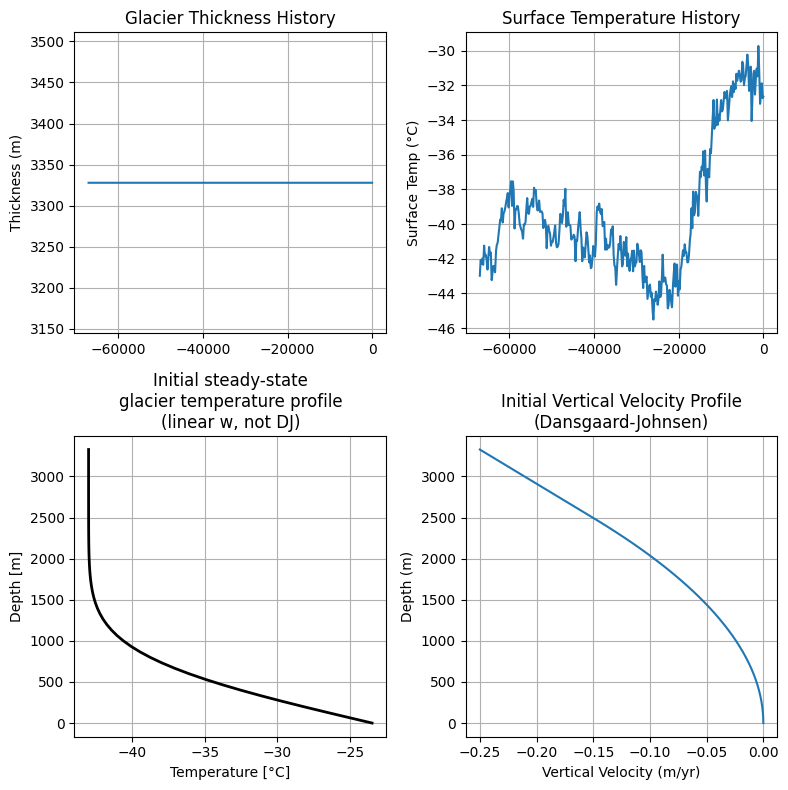

In [4]:
# Plot the thickness, surface temperature, and accumulation rate over time
import matplotlib.pyplot as plt 

plt.figure(figsize=(8, 8))

plt.subplot(221)
plt.plot(t_all / sec_per_yr, H(t_all))
plt.ylabel('Thickness (m)')
plt.title('Glacier Thickness History')
plt.grid(True)

plt.subplot(222)
plt.plot(t_all / sec_per_yr, T_surf(t_all))
plt.ylabel('Surface Temp (°C)')
plt.title('Surface Temperature History')
plt.grid(True)

plt.subplot(223)
plt.plot(T, z, 'k', lw=2)
plt.xlabel("Temperature [°C]")
plt.ylabel("Depth [m]")
plt.title("Initial steady-state\nglacier temperature profile\n(linear w, not DJ)")
plt.grid(True)

plt.subplot(224)
plt.plot(w(z, t_start) * sec_per_yr, z)
plt.xlabel('Vertical Velocity (m/yr)')
plt.ylabel('Depth (m)')
plt.title('Initial Vertical Velocity Profile\n(Dansgaard-Johnsen)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# --- main time loop ---
for n in range(nt):
    t = t_all[n]

    # Move grid to new surface height and interpolate T
    z_new = np.linspace(0.0, H(t + dt), nz)
    T     = np.interp(z_new, z, T)
    z     = z_new
    z_all[:, n+1] = z

    # Assemble and solve
    A, rhs = assemble_system(z, T, t, dt, kappa, q_g, k, w, T_surf, cap_temp=False)
    T = np.linalg.solve(A, rhs)

    # Save
    T_all[:, n+1] = T

# ------------------------------------------------------------
# Outputs:
#   T_all[z_index, t_index]  -> temperature [°C]
#   z_all[z_index, t_index]  -> depth grid [m]
#   t_all[t_index]           -> time [s]
# ------------------------------------------------------------
print("Done. Arrays available: T_all, z_all, t_all")
print(f"Final H = {H(t_all[-1]):.2f} m, Final T_surf = {T_surf(t_all[-1]):.2f} °C")


Done. Arrays available: T_all, z_all, t_all
Final H = 3327.92 m, Final T_surf = -32.65 °C


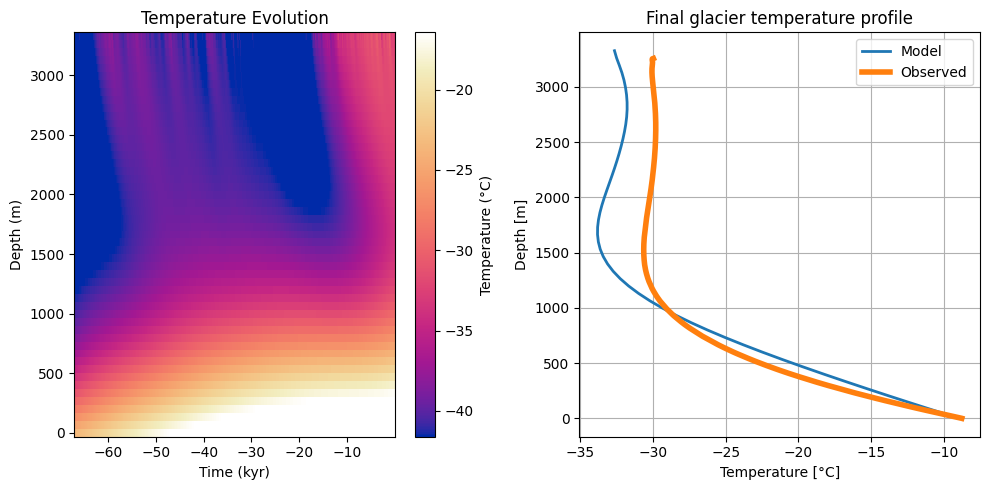

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
c=plt.pcolormesh(t_all/sec_per_yr/1e3,z,T_all,cmap='cet_CET_L17_r',vmin=np.percentile(T_all, 15), vmax=np.percentile(T_all, 95))
plt.colorbar(c,label='Temperature (°C)')
plt.xlabel('Time (kyr)')
plt.ylabel('Depth (m)')
plt.title('Temperature Evolution')

plt.subplot(122)
plt.plot(T_all[:,-1],z,label='Model', lw=2)
plt.xlabel("Temperature [°C]")
plt.ylabel("Depth [m]")
plt.title("Final glacier temperature profile")
plt.grid(True)

# load WAISDivide_borehole_Temperatures_dec2011.txt and plot on top
data = np.loadtxt('WAISDivide_borehole_Temperatures_dec2011.txt', skiprows=1)
depth_data = data[:, 0]  # depth in meters
temp_data = data[:, 1]   # temperature in °C
plt.plot(temp_data, max(depth_data)-depth_data, '-', label='Observed', lw=4)
plt.legend()

plt.tight_layout()
plt.show()